In [42]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from sklearn import preprocessing

### Task 2.1
### Least Square regression for missing value prediction

In [43]:
# Load the data into a matrix
data = np.loadtxt('whData.dat',
                  dtype=np.object,
                  comments='#',
                  delimiter=None)

# Separate out into separete vectors
H = data[:,1].astype('float32')      # Height
W = data[:,0].astype('float32')      # Weight

maxX = max(H)
maxY = max(W)

meanX = np.mean(H)
stdX = np.std(H)

# Find out indices containing no outliers (negative values)
mask = (W > 0).nonzero()
outlier_mask = (W <= 0).nonzero()

# Filter the clean data
dataX = H[mask]
dataY = W[mask]

# Scale the data in the range 0-1
scaled_dataX = dataX / maxX
scaled_dataY = dataY / maxY
n = len(dataX)

# Get the outlier data
outX = H[outlier_mask]
scaled_outX = outX / maxX

In [44]:
meanY = np.mean(W)
stdY = np.std(W)

normed_dataX = (dataX - meanX) / stdX
normed_dataY = (dataY - meanY) / stdY
normed_outX  = (outX - meanX)  / stdX

In [45]:
def vandermonde_matrix(x,d):
    mat = np.ones((len(x), d+1))
    
    for i in range(1,d+1):
        mat[:,i,None] = np.multiply(mat[:,i-1, None], x)
    return mat
        
def least_square_fitting_svd(X,y):
    return np.linalg.pinv(X).dot(y)

In [48]:
def plotFit(scaled_dataX, scaled_dataY, 
            scaled_tempX, scaled_tempY,
            scaled_outX, scaled_outY,
            
            normed_dataX, normed_dataY, 
            normed_tempX, normed_tempY,
            normed_outX, normed_outY,
            
            fig, pos):
    # ----------------------------------------------------------
    # Plot the fit on the scaled data 
    # ----------------------------------------------------------
    
    delta = (max(scaled_dataY) - min(scaled_dataY))/100.0    
    ax1 = fig.add_subplot(pos)
    ax1.set_xlabel('Height (cm)')
    ax1.set_ylabel('Weight (kg)')

    # Plot the fit curve
    ax1.plot(scaled_tempX, scaled_tempY, color='blue', label='best fit curve (d = %d)'% d)

    # Plot the original data points
    ax1.scatter(scaled_dataX, scaled_dataY, color='pink', label='data points')
    
    # Plot the outlier data and plot them
    ax1.scatter(scaled_outX, scaled_outY, color='green', label='prediciton for outliers')
    ax1.set_ylim([min(scaled_dataY)-10*delta, max(scaled_dataY)+10*delta])
    ax1.legend()

    # ----------------------------------------------------------
    # Plot the fit on the normed data 
    # ----------------------------------------------------------
    
    delta = (max(normed_dataY) - min(normed_dataY))/100.0    
    ax2 = fig.add_subplot(pos+1)
    ax2.set_xlabel('Height (cm)')
    ax2.set_ylabel('Weight (kg)')

    # Plot the fit curve
    ax2.plot(normed_tempX, normed_tempY, color='blue', label='best fit curve (d = %d)'% d)

    # Plot the original data points
    ax2.scatter(normed_dataX, normed_dataY, color='pink', label='data points')
    
    # Plot the outlier data and plot them
    ax2.scatter(normed_outX, normed_outY, color='green', label='prediciton for outliers')
    ax2.set_ylim([min(normed_dataY)-10*delta, max(normed_dataY)+10*delta])
    ax2.legend()

    return ax1, ax2

Prediction for d=1: [ 168.  172.  167.]

 [ 62.50890838  68.98114504  60.89084909]

Prediction for d=1: [ 168.  172.  167.]

 [ 62.50890016  68.98114944  60.89084233]

Prediction for d=5: [ 168.  172.  167.]

 [ 56.49103076  68.76739408  54.63510854]

Prediction for d=5: [ 168.  172.  167.]

 [ 56.49101613  68.76739892  54.63510011]

Prediction for d=10: [ 168.  172.  167.]

 [ 51.99999967  87.51881554  53.00000022]

Prediction for d=10: [ 168.  172.  167.]

 [ 49.00466919  78.48922729  54.45220947]



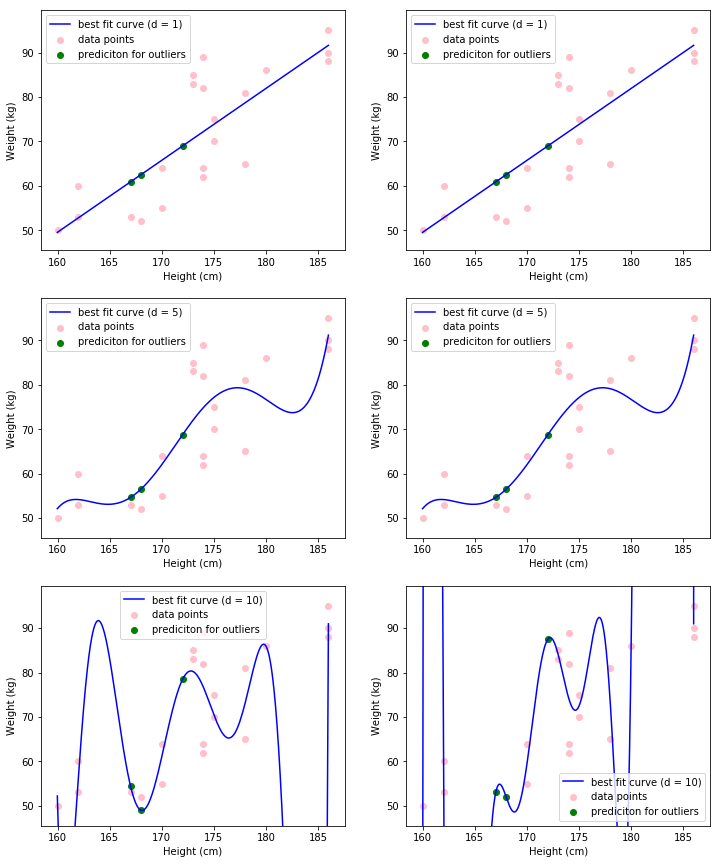

In [50]:
fig = plt.figure(figsize=(12,15))
axes = []
D = [1,5,10]

# Synthetic data to plot fit curve later
delta = (max(scaled_dataX) - min(scaled_dataX))/1000.0
scaled_tempX = np.arange(min(scaled_dataX)-delta, max(scaled_dataX)+delta, delta)

delta = (max(normed_dataX) - min(normed_dataX))/1000.0
normed_tempX = np.arange(min(normed_dataX)-delta, max(normed_dataX)+delta, delta)

for i, d in enumerate(D):
    # ----------------------------------------------------------
    # Fit in the normed data 
    # ----------------------------------------------------------
    
    # Compute the features for the data x
    normed_vandX = np.vander(normed_dataX, d+1, increasing=True)

    # Least square fitting, using svd, pseudo inverse
    w_svd = least_square_fitting_svd(normed_vandX, normed_dataY)
    
    # Make the prediction for the outlier points
    nOutX = len(normed_outX)
    normed_vecOutX = normed_outX.reshape(nOutX)
    normed_vandOutX = np.vander(normed_vecOutX, d+1, increasing=True)
    normed_outY = normed_vandOutX.dot(w_svd) 
    
    print("Prediction for d=%d: %s\n" % (d, (normed_outX.T * stdX + meanX)))
    print(" %s\n" % (normed_outY.T * stdY + meanY))
    
    normed_tempY = np.vander(normed_tempX, d+1, increasing=True).dot(w_svd)

    # ----------------------------------------------------------
    # Fit in the scaled data 
    # ----------------------------------------------------------
    # Compute the features for the data x
    scaled_vandX = np.vander(scaled_dataX, d+1, increasing=True)

    # Least square fitting, using svd, pseudo inverse
    w_svd = least_square_fitting_svd(scaled_vandX, scaled_dataY)
    
    # Make the prediction for the outlier points
    nOutX = len(scaled_outX)
    scaled_vecOutX = scaled_outX.reshape(nOutX)
    scaled_vandOutX = np.vander(scaled_vecOutX, d+1, increasing=True)
    scaled_outY = scaled_vandOutX.dot(w_svd)    
    print("Prediction for d=%d: %s\n" % (d, (scaled_outX.T * maxX)))
    print(" %s\n" % (scaled_outY.T * maxY))
    
    # Points for best fit curve
    scaled_tempY = np.vander(scaled_tempX, d+1, increasing=True).dot(w_svd)
    pos = 300 + 20 + 2*i+1
    ax1, ax2 = plotFit(scaled_dataX * maxX,
                       scaled_dataY * maxY, 
                       scaled_tempX * maxX, 
                       scaled_tempY * maxY, 
                       scaled_outX * maxX, 
                       scaled_outY * maxY, 
                 
                      normed_dataX * stdX + meanX,
                      normed_dataY * stdY + meanY,
                      normed_tempX * stdX + meanX,
                      normed_tempY * stdY + meanY,
                      normed_outX * stdX + meanX,
                      normed_outY * stdY + meanY,
                      fig, pos)
    axes.append(ax1)
    axes.append(ax2)
#plt.title('Polynomial fit with regression for the height and weight data')
plt.legend()
plt.show()

### Task 2.2
### Conditional expectation for missing value prediction

In [51]:
def cond_expectation_gaussion_2d(x, mean_x, mean_y, rho, std_x, std_y):
    return mean_y + rho * (std_y / std_x) * (x-mean_x)

def plot(x, y, 
         outlier_x, predicted, 
         std_x, std_y, 
         mean_x, mean_y,
         cov_xy):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)   
    ax.set_xlabel('Height (cm)')
    ax.set_ylabel('Weight (kg)')
    
    # Plot the original data points
    ax.scatter(x, y, color='pink', label='data points')
    
    # Plot the contour of fitted  gaussian
    x = np.arange(min(x)-2, max(x)+2, 0.1)
    y = np.arange(min(y)-10, max(y)+10, 0.1)
    X,Y = np.meshgrid(x,y)
    Z = matplotlib.mlab.bivariate_normal(X, Y, 
                                         sigmax=std_x, sigmay=std_y, 
                                         mux=mean_x, muy=mean_y, 
                                         sigmaxy=cov_xy)
    ax.contour(X, Y, Z)
    
    # Plot the prediction for outlier data points
    ax.scatter(outlier_x, predicted, color='green', label='prediction for outliers')
    ax.legend()
    plt.title('Gaussian fit for the height and weight data')
    plt.show()


### Fit p(h,w) with 2d Gaussian model

Method 1 : Unbiased empirical covariance using numpy:
[[  55.05714286   89.08571429]
 [  89.08571429  219.46190476]]

Method 2 : Unbiased Empirical covariance with formula:
[[  55.05714111   89.08571777]
 [  89.08571777  219.46191406]]

Method 3 : Unbiased Covariance with biased std devs
[[  55.05713707   89.08572008]
 [  89.08572008  219.46188981]]

Using the result from the third method:
Prediction for [ 168.  172.  167.] => [ 62.50891113  68.98114777  60.89085388]


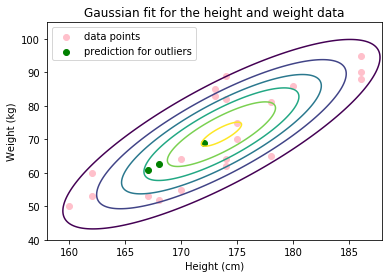

In [52]:
# Construt a single data matrix, height:x, weight:y
meanH = np.mean(dataX)
meanW = np.mean(dataY)

# Computing the covariance matrix in three ways for  better understanding
print("Method 1 : Unbiased empirical covariance using numpy:")
data_2d = np.concatenate((dataX.reshape(n,1), dataY.reshape(n,1)), axis=1).T
print(np.cov(data_2d))
print("")

print("Method 2 : Unbiased Empirical covariance with formula:")
# E[Xi,Xj] = 1/(n-1) * Sum_n (x^(n)[i] - mean_i) * (x^(n)[j] - mean_j)

h = dataX - meanH
w = dataY - meanW
cov_hh = h.T.dot(h)/float(len(h)-1)
cov_hw = h.T.dot(w)/float(len(h)-1)
cov_wh = w.T.dot(h)/float(len(h)-1)
cov_ww = w.T.dot(w)/float(len(h)-1)
print(np.array([[cov_hh, cov_hw],[cov_wh, cov_ww]]))
print("")

print("Method 3 : Unbiased Covariance with biased std devs")
stdH = np.std(dataX, ddof=1)
stdW = np.std(dataY, ddof=1)

cov_wh = w.T.dot(h)/float(len(h)-1)
cov_hw = h.T.dot(w)/float(len(h)-1)

corr_wh = cov_wh / (stdH*stdW)

cov_hh = stdH**2
cov_wh = corr_wh * stdH * stdW
cov_hw = cov_wh
cov_ww = stdW**2

print(np.array([[cov_hh, cov_hw],[cov_wh, cov_ww]]))
print("")

# We use the result of method 3
rho = corr_wh

# Predict the weight for outlier data
outY = cond_expectation_gaussion_2d(outX, meanH, meanW, rho, stdH, stdW)

print("Using the result from the third method:")
print("Prediction for %s => %s" % (outX.T, outY.T))
plot(dataX, dataY, outX, outY, stdH, stdW, meanH, meanW, cov_hw)   

### Task 2.3 Bayesian regression for missing value prediction

In [53]:
def plotFit(dataX, dataY, 
        tempX, tempY_MLE, tempY_ML,
        outX,   outY_MLE,  outY_ML,
        fig):

    ax = fig.add_subplot(111)
    ax.set_xlabel('Height (cm)')
    ax.set_ylabel('Weight (kg)')

    # Plot the original data points
    ax.scatter(dataX, dataY, color='pink', label='data points')
    
    # Plot the fit curve: bayesian regression
    ax.plot(tempX, tempY_MLE, 
             color='green', label='Bayesian regression fit')
    
    # Plot the fit curve: Least square regression
    ax.plot(tempX, tempY_ML, 
             color='blue', label='Least Square Regression')
    
    # Plot the outlier data: Bayesian Regression
    ax.scatter(outX, outY_MLE, 
                color='green', label='outlier')
    ax.scatter(outX, outY_ML, 
                color='blue', label='oulier')
    
    ax.legend()
    
    return ax

Prediction (bayesian regression)
[[ 60.39633001  68.18734448  58.72012844]]
Prediction (least square regression)
[ 58.66425631  69.56691736  56.01518391]


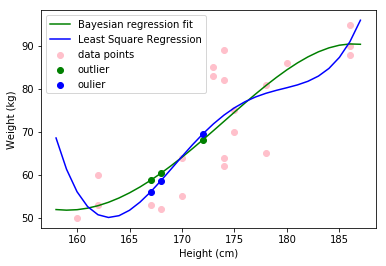

In [55]:
# Fit the fifth-degree polynomial on the given 2d data
# with bayesian regression
# y(x) = sum_{j=0}^{5} w_j * x^j + noise_i

""" 
Want: p(y | x,D) = integrate p(y | x,D,w) * p(w | x,D) dw
                 = integrate p(y | x,w) * p(w | D) dw
                 = N(y | v, 1/lambda)

Calculate: p(w | D) ~ p(D | w) . P(w)
                    ~ N(w | mu_w, precision_matrix_inverse)
Assumptions: 
             (1) y_i ~ N(y | w.T.dot(x_i), var_err) 
             (2) w   ~ N(w | mu_0, var_0*I) 

"""
mu_0  = 0.0
var_0 = 3.0
var=4.0
d = 5

# Data
vandX = np.vander(dataX, d+1, increasing=True)
vecY  = dataY.reshape(n,1)

# Baysian fitting
w_MLE = np.linalg.inv(vandX.T.dot(vandX) + (var/var_0) * np.identity(d+1)).dot(vandX.T).dot(vecY)

# Least square fitting from task 2.1
w_ML = least_square_fitting_svd(vandX, dataY)

# Produce fit curve
tempX = np.arange(min(dataX)-2, max(dataX)+2)
vand_tempX = np.vander(tempX, d+1, increasing=True)
tempY_MLE = vand_tempX.dot(w_MLE)
tempY_ML = vand_tempX.dot(w_ML)

# Prediction on the outlier
vand_outX = np.vander(outX, d+1, increasing=True)
outY_MLE = vand_outX.dot(w_MLE)
outY_ML = vand_outX.dot(w_ML)

print("Prediction (bayesian regression)")
print(outY_MLE.T)
print("Prediction (least square regression)")
print(outY_ML.T)

fig = plt.figure()
ax = plotFit(dataX, dataY, 
        tempX, tempY_MLE, tempY_ML,
        outX, outY_MLE,  outY_ML,
        fig)
plt.show()

#precision_matrix = 1.0/var * vandX.T.dot(vandX) + 1.0/var_0 * np.identity(d+1)
#mu = 1.0/var * np.linalg.inv(precision_matrix).dot(vandX.T).dot(vecY)


### Task 2.4 Boolean functions and the Boolean Fourier Transform

In [121]:
def binary_data_matrix(num_bits=3):
    n = np.power(2, num_bits)
    digits = np.array(range(n)[::-1]).reshape(n,1)
    X = (np.unpackbits(np.uint8(digits), axis=1)[:,-3:]).astype(np.float32) * 2. - 1.
    return X

def binary_target(rule_no):
    target = np.flip(np.unpackbits([np.uint8(rule_no)]).astype(np.float32), axis=0) * 2 - 1
    return target.reshape(len(target),1)

In [129]:
X = binary_data_matrix(num_bits=3)
print("Data Matrix: ")
print(X)

Data Matrix: 
[[ 1.  1.  1.]
 [ 1.  1. -1.]
 [ 1. -1.  1.]
 [ 1. -1. -1.]
 [-1.  1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1. -1.]]


In [140]:
y_rule110 = binary_target(rule_no=100)
y_rule126 = binary_target(rule_no=126)

w_rule110 = np.linalg.pinv(X).dot(y_rule110)
w_rule126 = np.linalg.pinv(X).dot(y_rule126)

print("rule 110 =====================")
print("w: ")
print(w_rule110)
print("")

print("prediction: ")
print(X.dot(w_rule110))
print("")

print("rule 126 =====================")
print("w: ")
print(w_rule126)
print("")

print("prediction: ")
print(X.dot(w_rule126))
print("")

rule 110 =====================
w: 
[[-0.24999999]
 [-0.24999999]
 [ 0.24999999]]

prediction: 
[[-0.24999999]
 [-0.74999994]
 [ 0.24999999]
 [-0.24999999]
 [ 0.24999999]
 [-0.24999999]
 [ 0.74999994]
 [ 0.24999999]]

rule 126 =====================
w: 
[[ 0.]
 [ 0.]
 [ 0.]]

prediction: 
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

